In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MDAnalysis as mda
from MDAnalysis.analysis import rms

#import xmlrpc.client as xmlrpclib
#cmd = xmlrpclib.ServerProxy('http://localhost:9123')

/home/evasmo/anaconda3/envs/macromol/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = '/home/evasmo/work/kcn/md_conformations/'

In [3]:
files = [f for f in os.listdir(path) if f.endswith('.pdb')]

In [4]:
KCNN4_qty_solvent = [f for f in files if 'KCNN4_qty_solvent' in f]
KCNN4_qty_membrane = [f for f in files if 'KCNN4_qty_400ns' in f]
KCNN4_cryoem = [f for f in files if 'KCNN4_cryoem_400ns' in f]
KCNN4_native = [f for f in files if 'KCNN4_native_400ns' in f]

KCNJ11_qty_solvent = [f for f in files if 'KCNJ11_qty_solvent' in f]
KCNJ11_qty_membrane = [f for f in files if 'KCNJ11_qty_400ns' in f]
KCNJ11_cryoem = [f for f in files if 'KCNJ11_cryoem_400ns' in f]
KCNJ11_native = [f for f in files if 'KCNJ11_native_400ns' in f]

In [5]:
def group_rmsd(qty_solvent, qty_membrane, cryoem, native, path = path):

    # Function to load universe
    def load_universe(file, path = path):
        return mda.Universe(path + file)
    
    # Load structures
    solvent_structures = [load_universe(f) for f in qty_solvent]
    membrane_structures = [load_universe(f) for f in qty_membrane]
    cryoem_structures = [load_universe(f) for f in cryoem]
    native_structures = [load_universe(f) for f in native]
    
    # All structures combined in a list with group names
    groups = ['solvent', 'membrane', 'cryoem', 'native']
    all_structures = solvent_structures + membrane_structures + cryoem_structures + native_structures
    group_indices = {'solvent': range(len(solvent_structures)),
                     'membrane': range(len(solvent_structures), len(solvent_structures) + len(membrane_structures)),
                     'cryoem': range(len(solvent_structures) + len(membrane_structures),
                                    len(solvent_structures) + len(membrane_structures) + len(cryoem_structures)),
                     'native': range(len(solvent_structures) + len(membrane_structures) + len(cryoem_structures),
                                     len(all_structures))}
    
    # Function to calculate pairwise RMSD
    def calculate_pairwise_rmsd(structures):
        n = len(structures)
        rmsd_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                rmsd_analysis = rms.RMSD(structures[i], structures[j], select='protein and name CA')
                rmsd_analysis.run()
                rmsd_value = rmsd_analysis.rmsd[:, -1][-1]
                rmsd_matrix[i, j] = rmsd_value
                rmsd_matrix[j, i] = rmsd_value
        return rmsd_matrix
    
    # Calculate RMSD for all structures
    rmsd_matrix = calculate_pairwise_rmsd(all_structures)
    
    # Create labels for DataFrame
    labels = []
    for group in groups:
        labels.extend([f"{group}_{i}" for i in group_indices[group]])
    
    # Create DataFrame
    rmsd_df = pd.DataFrame(rmsd_matrix, index=labels, columns=labels)
    
    return rmsd_df


def compare_rmsd(qty_solvent, qty_membrane, cryoem, native, path = path):

    # Function to load universe
    def load_universe(file, path = path):
        return mda.Universe(path + file)
    
    # Load structures
    solvent_structures = [load_universe(f) for f in qty_solvent]
    membrane_structures = [load_universe(f) for f in qty_membrane]
    cryoem_structures = [load_universe(f) for f in cryoem]
    native_structures = [load_universe(f) for f in native]
    
    # All structures combined in a list with group names
    groups = ['solvent', 'membrane', 'cryoem', 'native']
    all_structures = solvent_structures + membrane_structures + cryoem_structures + native_structures
    group_indices = {'solvent': range(len(solvent_structures)),
                     'membrane': range(len(solvent_structures), len(solvent_structures) + len(membrane_structures)),
                     'cryoem': range(len(solvent_structures) + len(membrane_structures),
                                    len(solvent_structures) + len(membrane_structures) + len(cryoem_structures)),
                     'native': range(len(solvent_structures) + len(membrane_structures) + len(cryoem_structures),
                                     len(all_structures))}
    
    # Function to calculate pairwise RMSD
    def calculate_pairwise_rmsd(structures):
        n = len(structures)
        rmsd_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                rmsd_analysis = rms.RMSD(structures[i], structures[j], select='protein and name CA')
                rmsd_analysis.run()
                rmsd_value = rmsd_analysis.rmsd[:, -1][-1]
                rmsd_matrix[i, j] = rmsd_value
                rmsd_matrix[j, i] = rmsd_value
        return rmsd_matrix
    
    # Calculate RMSD for all structures
    rmsd_matrix = calculate_pairwise_rmsd(all_structures)
    
    # Create labels for DataFrame
    labels = []
    for group in groups:
        labels.extend([f"{group}_{i}" for i in group_indices[group]])


    rmsd_df = pd.DataFrame(rmsd_matrix, index=labels, columns=labels)
    def get_pairwise_rmsd_values(group1, group2):
        indices1 = group_indices[group1]
        indices2 = group_indices[group2]
        values = []
        for i in indices1:
            for j in indices2:
                if i != j:  # exclude self-comparison
                    values.append(rmsd_df.iloc[i, j])
        return values
    
    # Collect RMSD values for each pairwise comparison
    rmsd_values = {}
    for i, group1 in enumerate(groups):
        for j, group2 in enumerate(groups):
            if i < j:
                comparison = f"{group1} vs. {group2}"
                rmsd_values[comparison] = get_pairwise_rmsd_values(group1, group2)

    df = pd.DataFrame(rmsd_values)
    return rmsd_df, df

In [6]:
KCNN4_matrix, KCNN4_df = compare_rmsd(KCNN4_qty_solvent, KCNN4_qty_membrane, KCNN4_cryoem, KCNN4_native)
KCNJ11_matrix, KCNJ11_df = compare_rmsd(KCNJ11_qty_solvent, KCNJ11_qty_membrane, KCNJ11_cryoem, KCNJ11_native)

/home/evasmo/anaconda3/envs/macromol/lib/python3.11/site-packages/MDAnalysis/analysis/base.py:447: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time
/home/evasmo/anaconda3/envs/macromol/lib/python3.11/site-packages/MDAnalysis/coordinates/base.py:753: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.time
/home/evasmo/anaconda3/envs/macromol/lib/python3.11/site-packages/MDAnalysis/analysis/rms.py:722: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


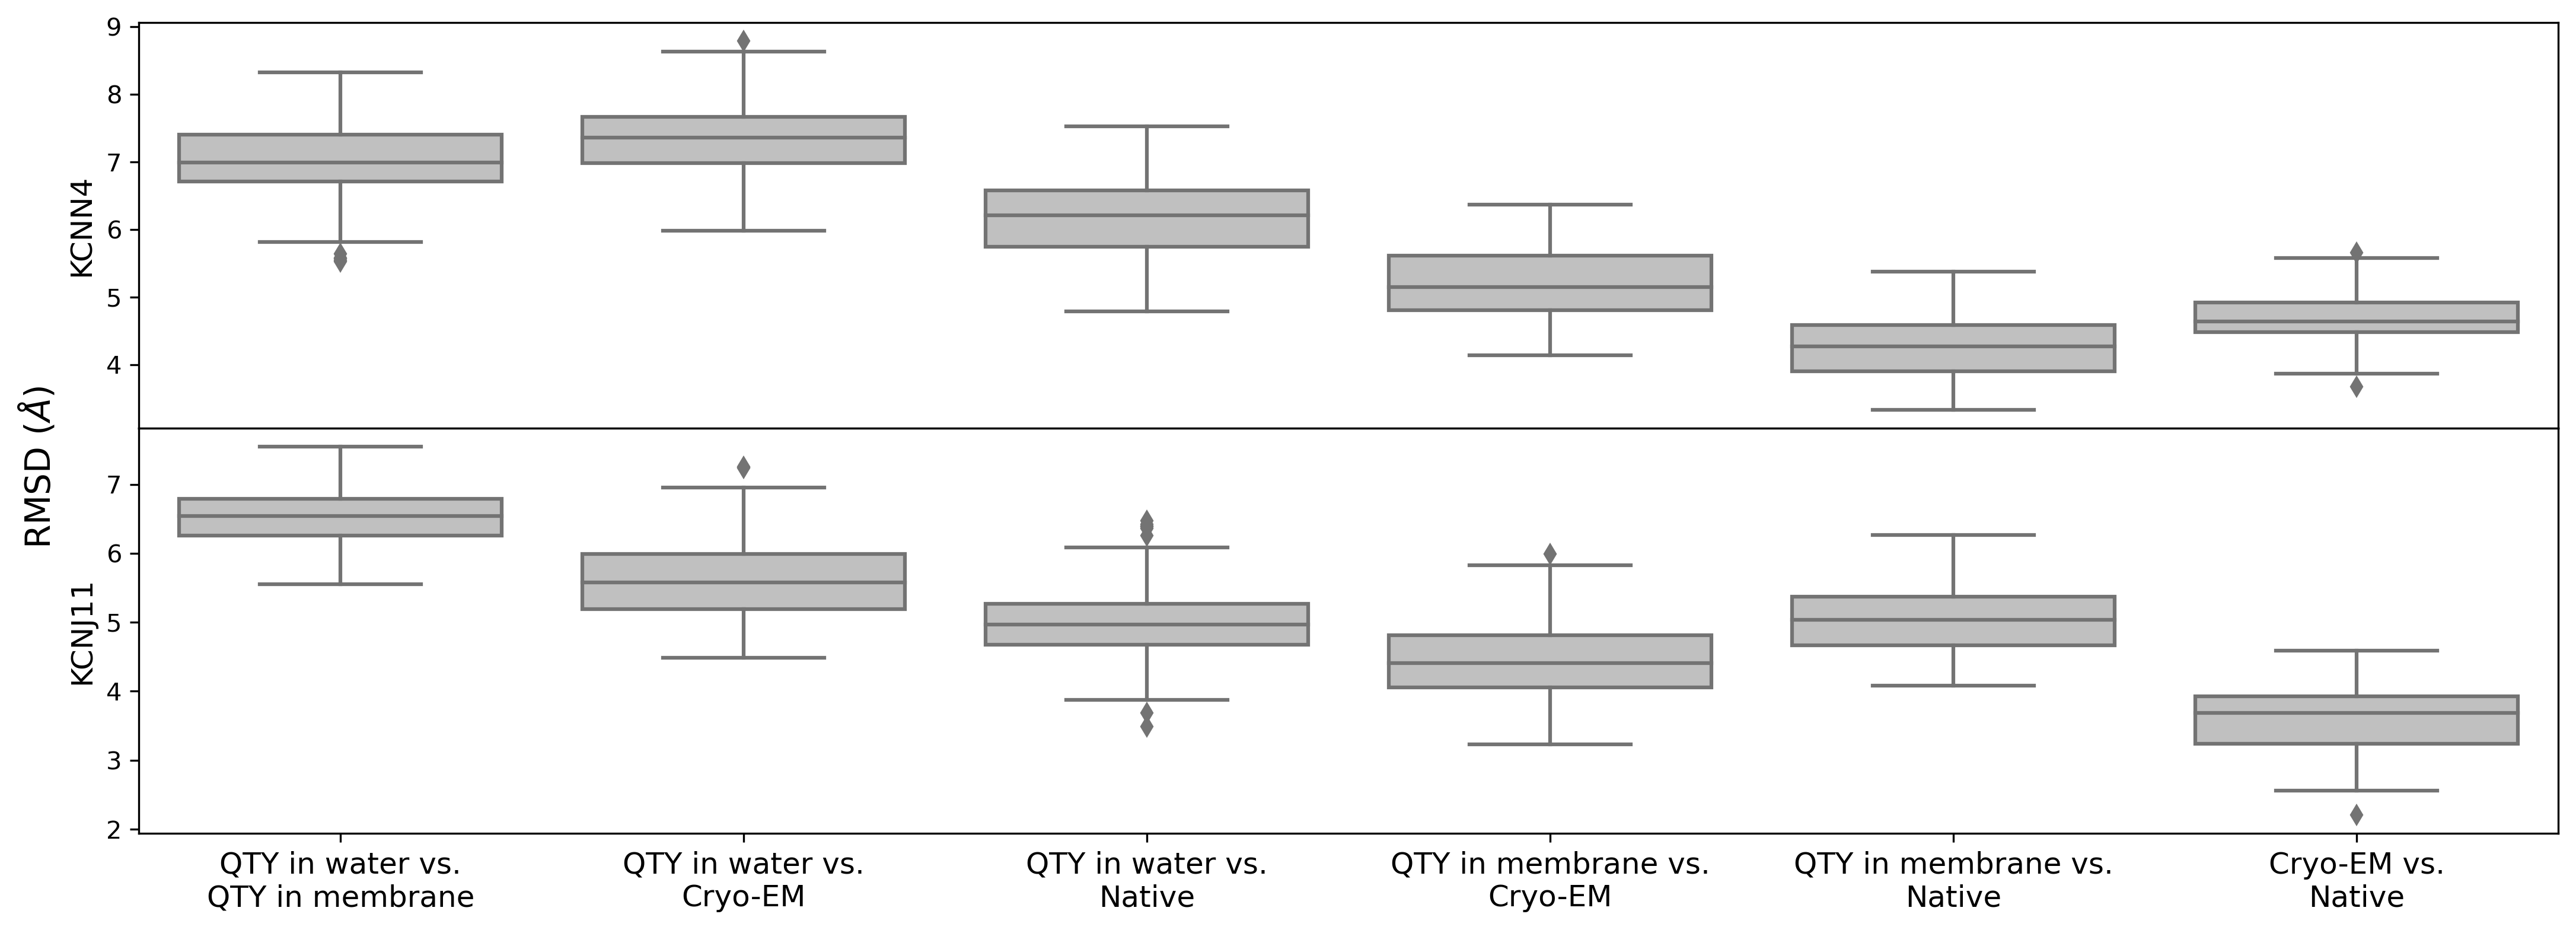

In [7]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 5), dpi = 300)
axs = axs.flatten()

sns.boxplot(data = KCNN4_df, color = '#C0C0C0', ax = axs[0])
sns.boxplot(data = KCNJ11_df, color = '#C0C0C0', ax = axs[1])
axs[0].set_xticks([])

labels = ['QTY in water vs.\nQTY in membrane', 'QTY in water vs.\nCryo-EM', 'QTY in water vs.\nNative', 'QTY in membrane vs.\nCryo-EM', 'QTY in membrane vs.\nNative', 'Cryo-EM vs.\nNative']
axs[1].set_xticklabels(labels, fontsize = 12)

axs[0].set_ylabel('KCNN4', fontsize = 12)
axs[1].set_ylabel('KCNJ11', fontsize = 12)

fig.text(-0.02, 0.5, r'RMSD ($\AA$)', va='center', rotation='vertical', fontsize = 14)

plt.tight_layout(pad = 0)
plt.show()